## Q1.1 Data transformation

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns

#### Getting all unique parameters

In [ ]:
csv_directory = "data/set-a/"
unique_parameters = set()

# Looping through each patient file and gathering the parameter name
for filename in os.listdir(csv_directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(csv_directory, filename)
        
        with open(file_path, mode='r') as file:
            reader = csv.reader(file)
            for row in reader:
                # Get row parameter name and add to set
                parameter = row[1]
                unique_parameters.add(parameter)

unique_parameters = list(unique_parameters)
unique_parameters.sort()
unique_parameters.remove("ICUType")
unique_parameters.remove("Parameter")

print("Unique Parameters:", unique_parameters)
print(len(unique_parameters))

#### Creating a large table for all patients

In [24]:
# Run this code for each of the sets once to create corresponding .parquet file (change folder names in lines 2 and 40 to "set-x")
file_paths = glob.glob("data/set-c/*.txt")

processed_dfs = []

# Loops through each of the patient .txt file and creates corresponding table. In the end, appends all tables to one big table and saves it as .parquet file
for file in file_paths:
    df = pd.read_csv(file)
    
    # For rounding to the next hour
    df[['Hour', 'Minute']] = df['Time'].str.split(':', expand=True).astype(int)
    df['RoundedHour'] = np.where((df['Hour'] == 0) & (df['Minute'] == 0), 0, ((df['Hour'] * 60 + df['Minute']) // 60 + 1) * 60)
    df['Time'] = df['RoundedHour'].apply(lambda x: f"{x//60:02}:00")

    # If we have two measurements during one hour (e.g, at 00:37 and at 00:57), we take the mean and get one value for the timestamp 01:00
    df_pivot = df.pivot_table(index='Time', columns='Parameter', values='Value', aggfunc='mean').reset_index()

    # Ensure all hours from 00:00 to 48:00 are present
    full_hours = pd.DataFrame({"Time": [f"{h:02}:00" for h in range(49)]})
    df_final = full_hours.merge(df_pivot, on="Time", how="left")

    # Add missing parameters from unique_parameters with NaN values (since not all parameters are measured on one patient)
    for param in unique_parameters:
        if param not in df_final.columns:
            df_final[param] = np.nan

    # Enforce static values to be persistent over all timestamps
    df_final["Age"] = df_final["Age"][0]
    df_final["Height"] = df_final["Height"][0]
    df_final["Weight"] = df_final["Weight"][0]
    df_final["Gender"] = df_final["Gender"][0]
    df_final["RecordID"] = df_final["RecordID"][0]

    processed_dfs.append(df_final)

final_df = pd.concat(processed_dfs, ignore_index=True)

# Saving result and displaying a preview
final_df.to_parquet('processed-data/processed-set-c.parquet', index=False)
final_df.head()

#### Getting the labels from Outcomes-x.txt files and creating corresponding .parquet files

In [25]:
# Run this code for each of the sets once to create corresponding .parquet file (change folder names in lines 2 and 4 to "set-x")
file_paths = ["data/Outcomes-a.txt", "data/Outcomes-b.txt", "data/Outcomes-c.txt"]
for file_path in file_paths:
    df = pd.read_csv(file_path)
    df_labels = df[["RecordID","In-hospital_death"]]
    if file_path.startswith("data/Outcomes-a"):
        df_labels.to_parquet('processed-data/processed-outcomes-a.parquet', index=False)
    elif file_path.startswith("data/Outcomes-b"):
        df_labels.to_parquet('processed-data/processed-outcomes-b.parquet', index=False)
    else:
        df_labels.to_parquet('processed-data/processed-outcomes-c.parquet', index=False)

## Q1.2 Exploratory Data Analysis

#### Visualizing the data

In [28]:
df = pd.read_parquet('processed-data/processed-set-a.parquet')
print(df.head())

    Time   Age   BUN  Creatinine   GCS  Gender  Glucose  HCO3   HCT     HR  \
0  00:00  35.0   NaN         NaN   NaN     0.0      NaN   NaN   NaN    NaN   
1  01:00  35.0   NaN         NaN   NaN     0.0      NaN   NaN   NaN    NaN   
2  02:00  35.0   NaN         NaN  15.0     0.0      NaN   NaN   NaN  112.0   
3  03:00  35.0  68.0         2.3   NaN     0.0    603.0  11.0  25.5  113.0   
4  04:00  35.0   NaN         NaN   NaN     0.0      NaN   NaN   NaN  112.0   

   ...  FiO2  Lactate  MAP  MechVent  PaCO2  PaO2  SaO2  SysABP  TroponinI  pH  
0  ...   NaN      NaN  NaN       NaN    NaN   NaN   NaN     NaN        NaN NaN  
1  ...   NaN      NaN  NaN       NaN    NaN   NaN   NaN     NaN        NaN NaN  
2  ...   NaN      NaN  NaN       NaN    NaN   NaN   NaN     NaN        NaN NaN  
3  ...   NaN      NaN  NaN       NaN    NaN   NaN   NaN     NaN        NaN NaN  
4  ...   NaN      NaN  NaN       NaN    NaN   NaN   NaN     NaN        NaN NaN  

[5 rows x 43 columns]


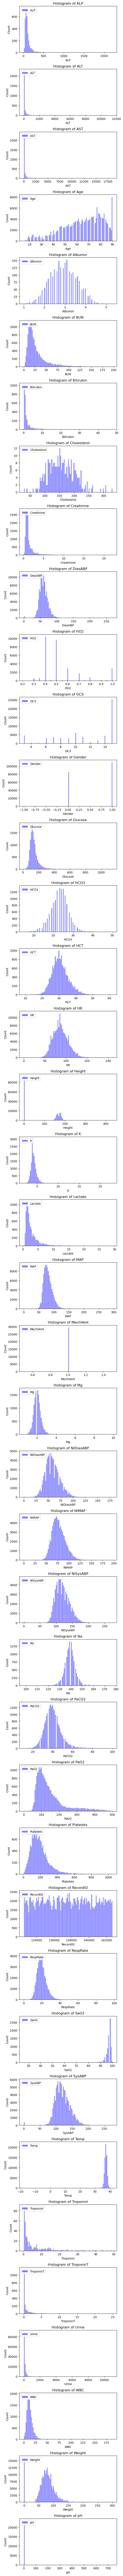

In [29]:
# Histograms of all parameters

df = pd.read_parquet('processed-data/processed-set-a.parquet')

N_points = 196000
n_bins = 100

fig, axs = plt.subplots(nrows=len(unique_parameters), ncols=1, figsize=(6, len(unique_parameters) * 3))

for i, e in enumerate(unique_parameters):
    current_row = np.array(df[e], dtype=float)
    # Remove NaNs
    current_row = current_row[~np.isnan(current_row)]  

    axs[i].hist(current_row, bins=n_bins, density=False, alpha=0.5, color='b', edgecolor='white')
    axs[i].set_title(f"Histogram of {e}")
    axs[i].set_xlabel(e)
    axs[i].set_ylabel("Count")
    axs[i].legend([e], loc='upper left')

plt.tight_layout()
plt.show()

#### Observation
We can observe the typical normally distributed bell shape quite often. However, there are variables, we we can see a different pattern. For example, for both the variables "Height" and "Weight" it can be observed that their value is sometimes equal to "-1.0". We think that this is a different way of saying that there was no measurement taken for these variables at that point in time, meaning it should essentially be a NaN value. Additionally, the variable "Gender" is simply encoded as "1.0" or "0.0" standing for either male or female.

/var/folders/cl/6x22s11x35x9ft87zz01_7r80000gn/T/ipykernel_73258/96325806.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


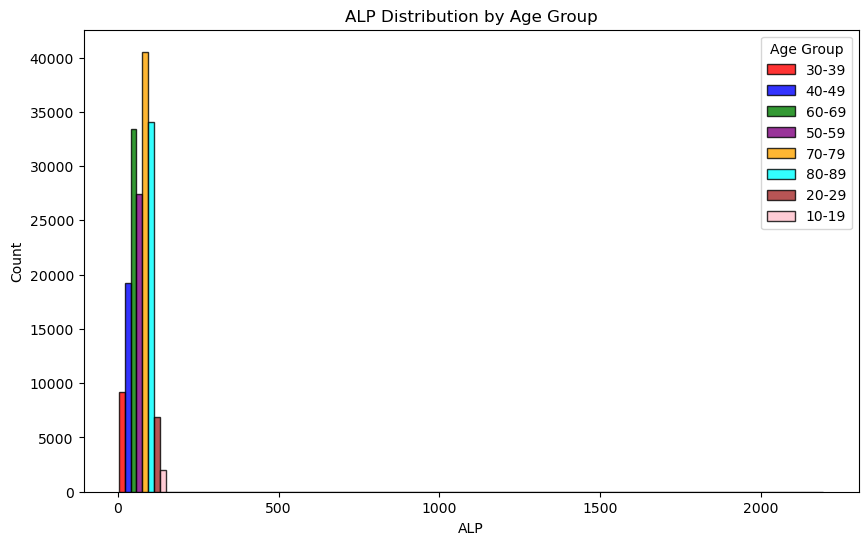

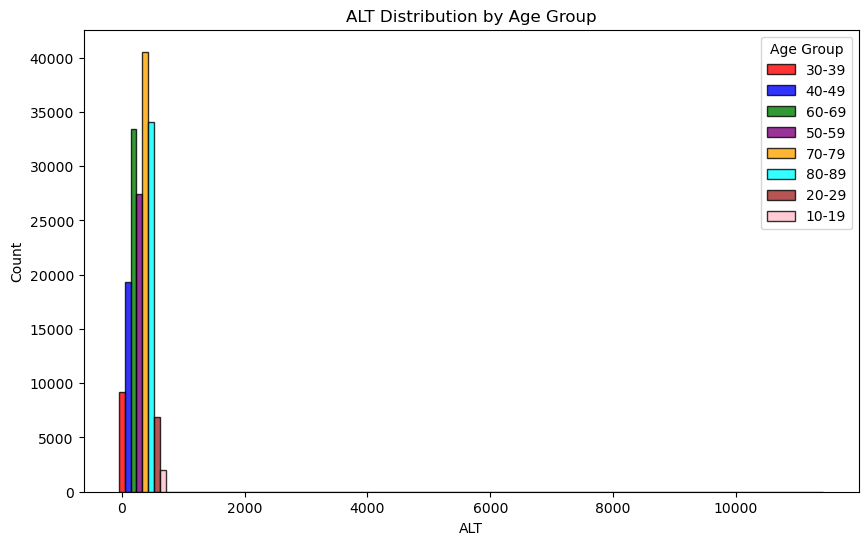

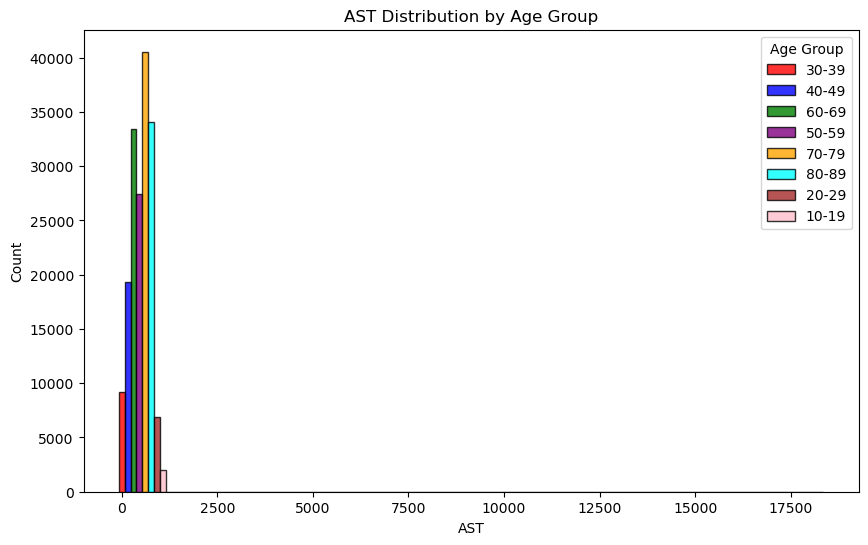

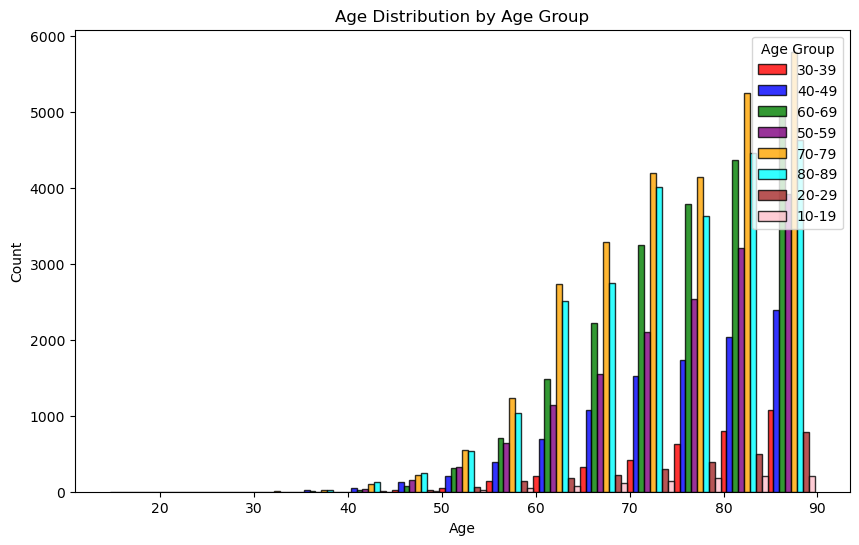

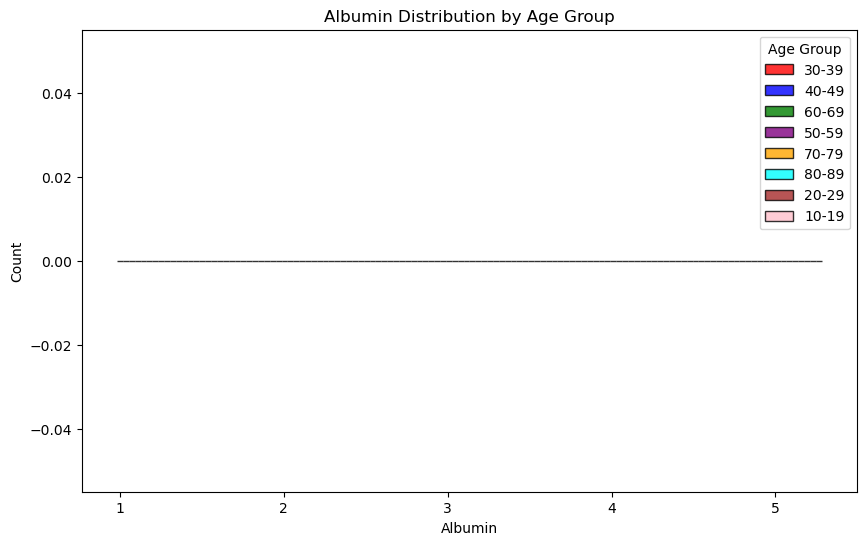

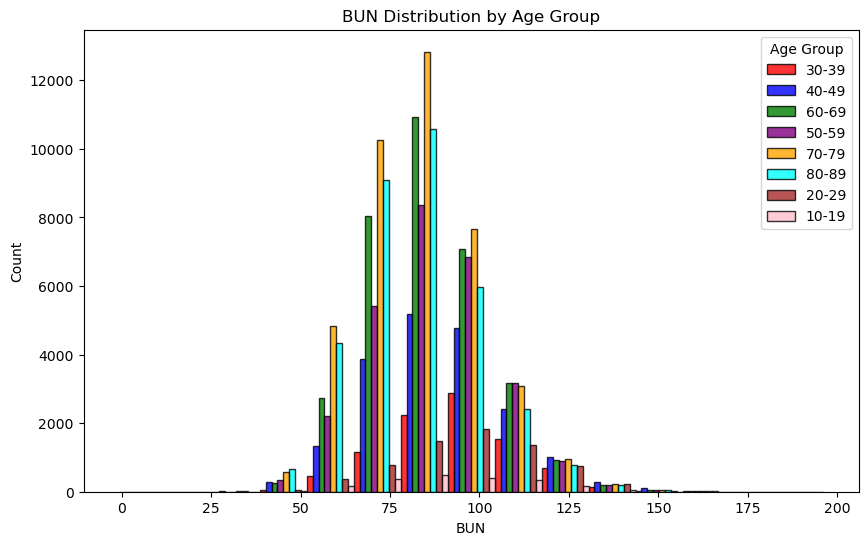

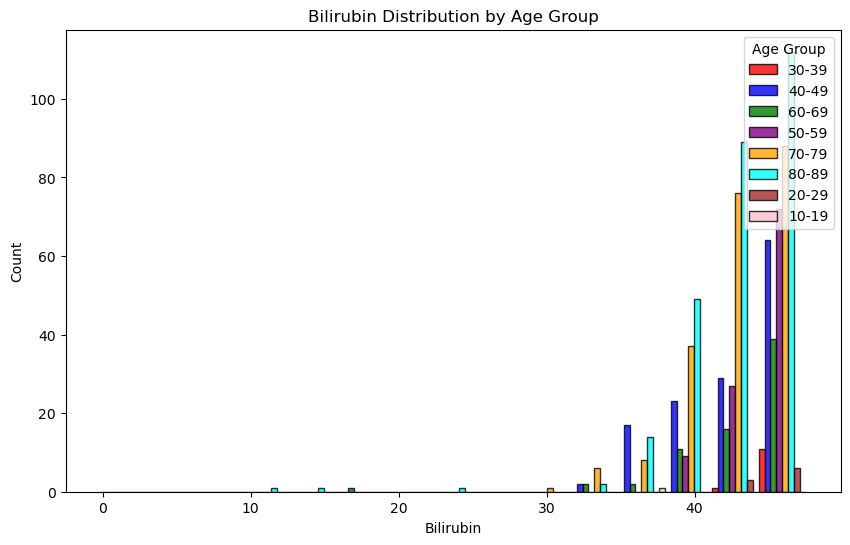

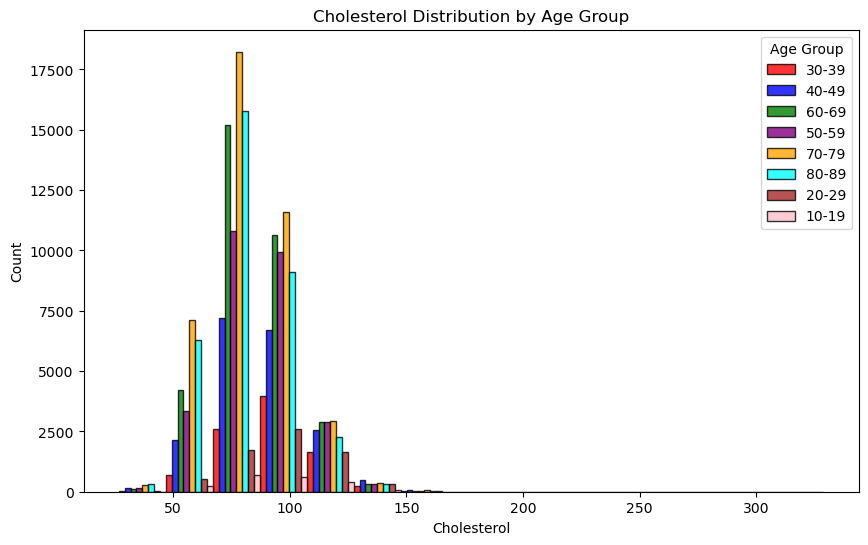

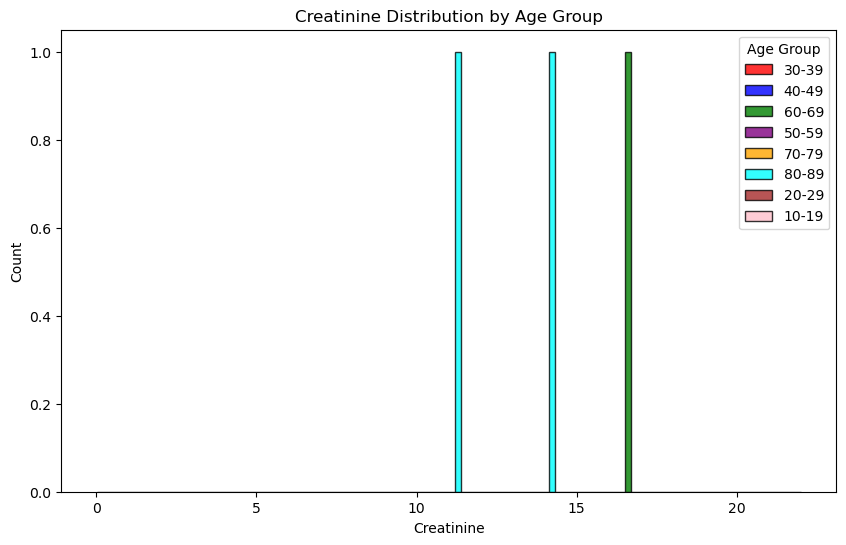

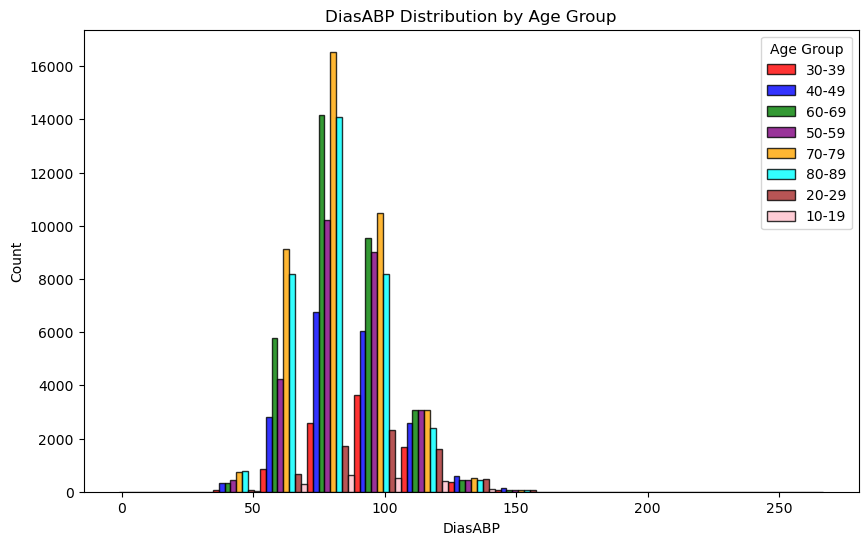

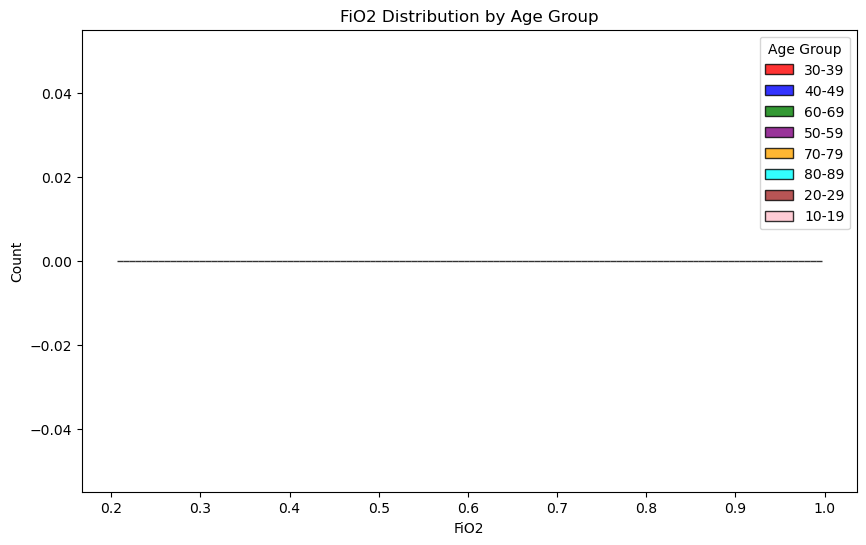

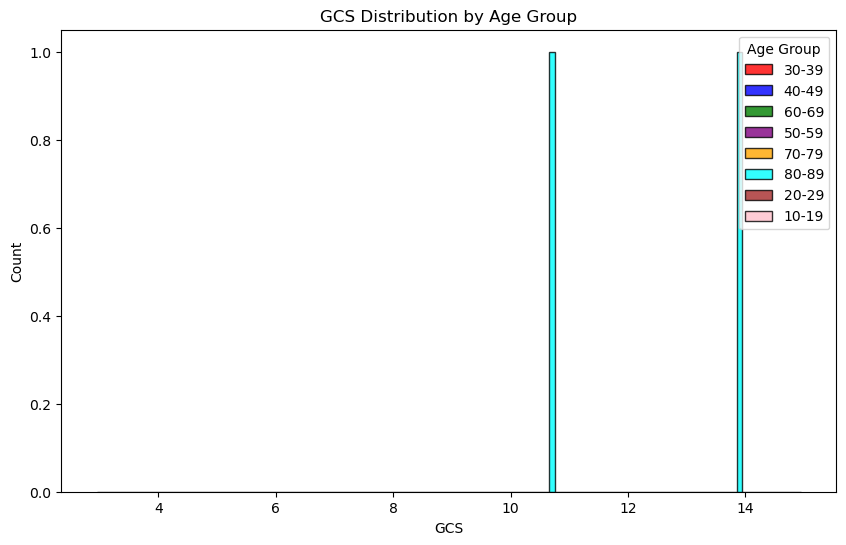

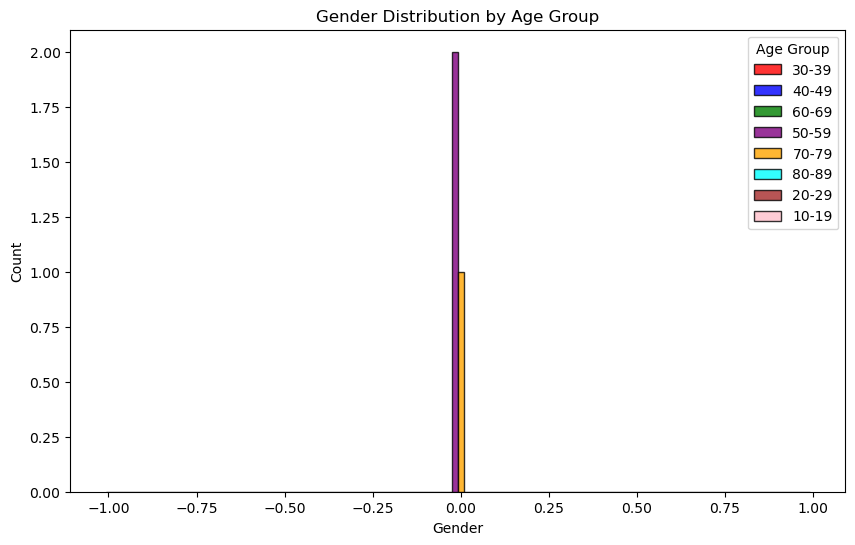

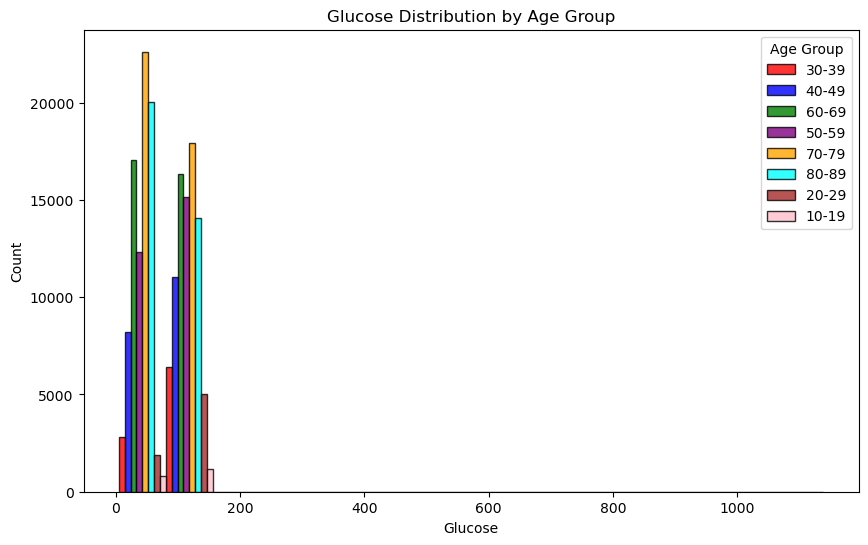

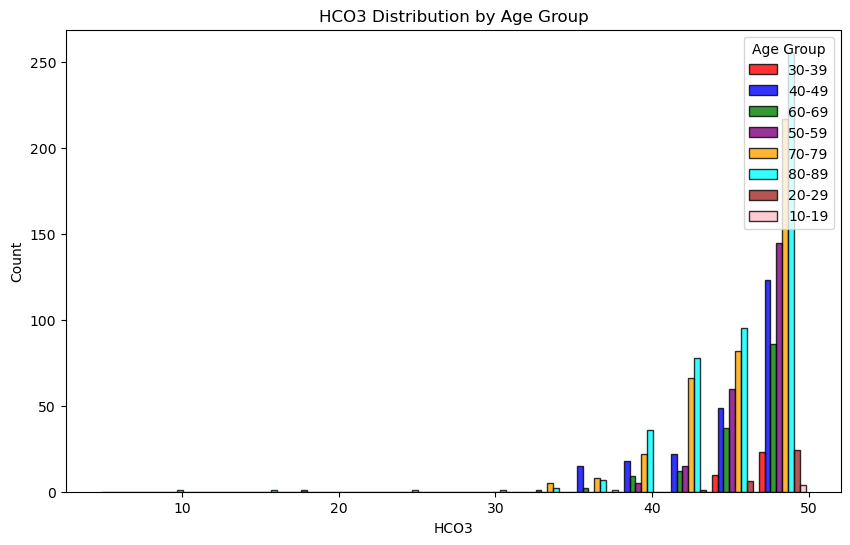

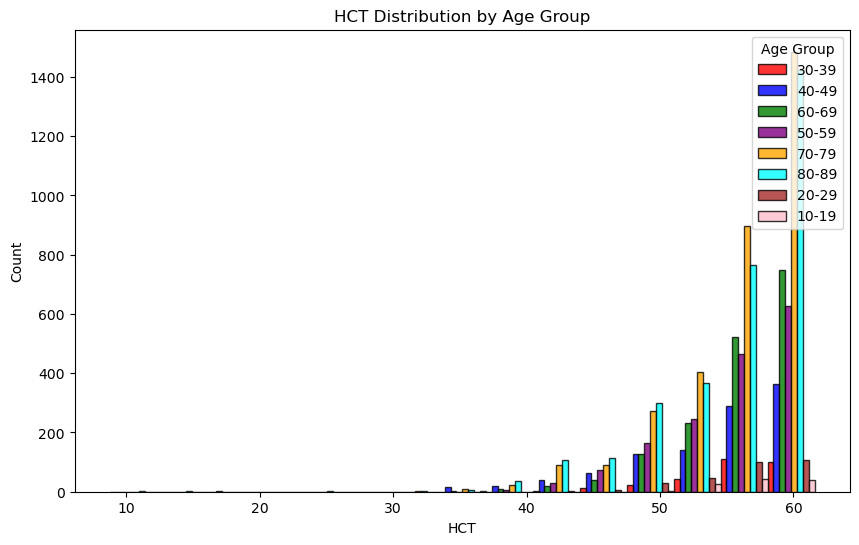

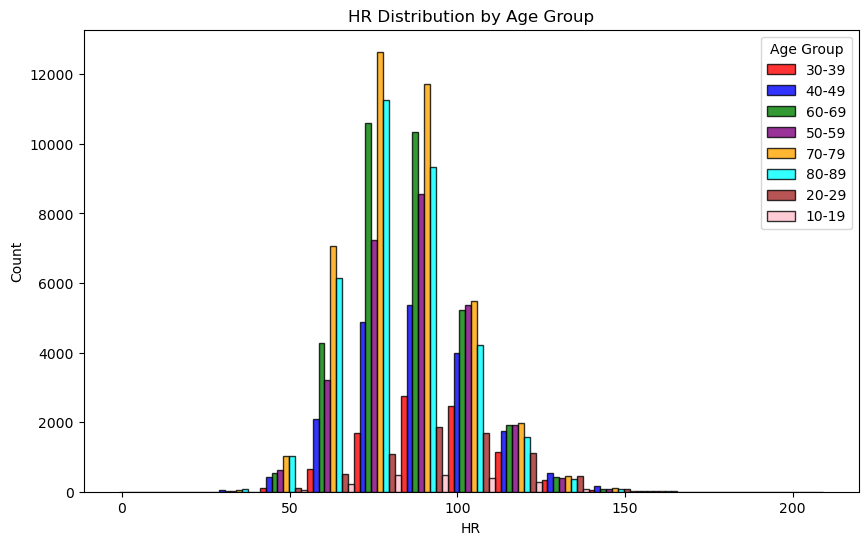

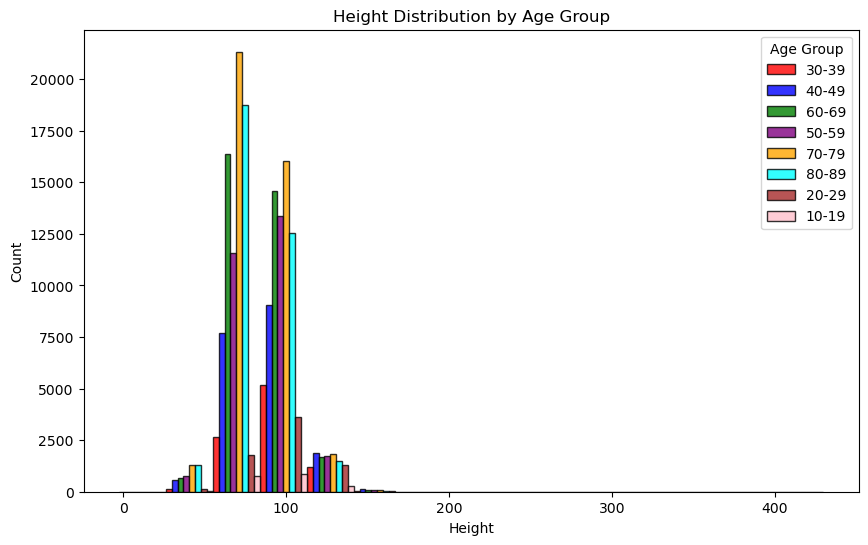

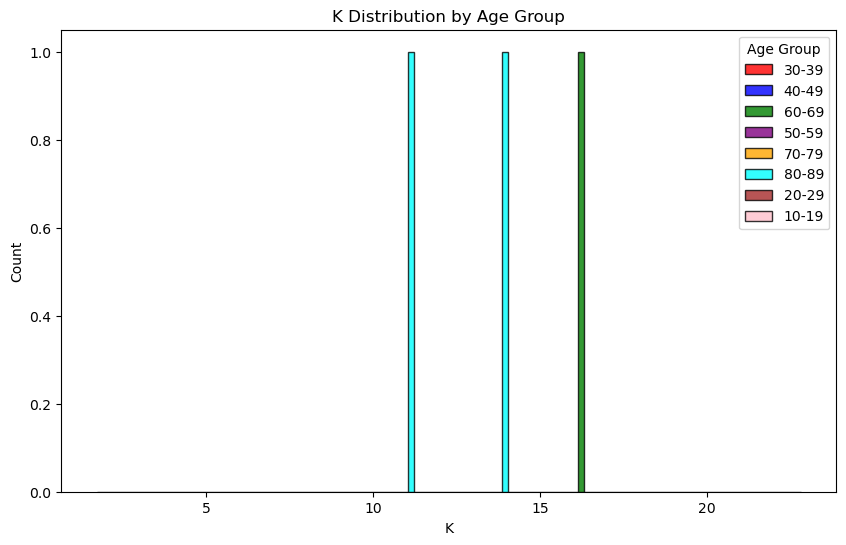

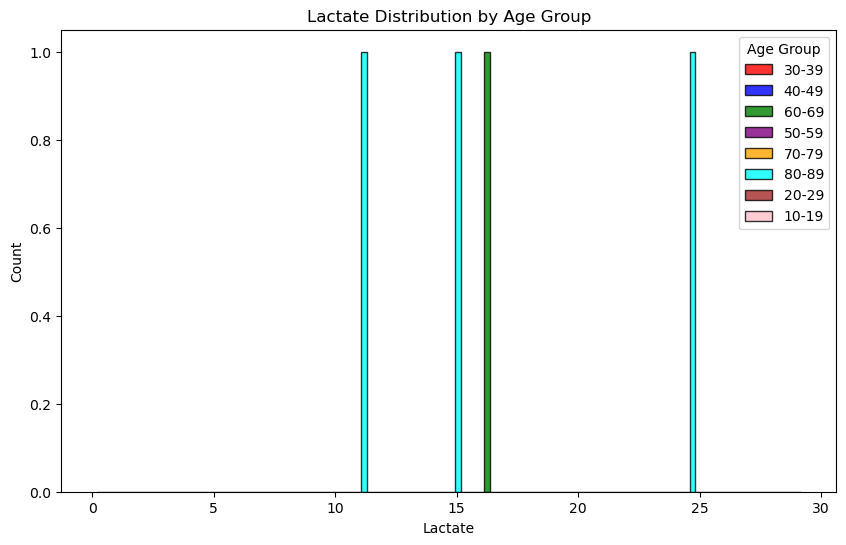

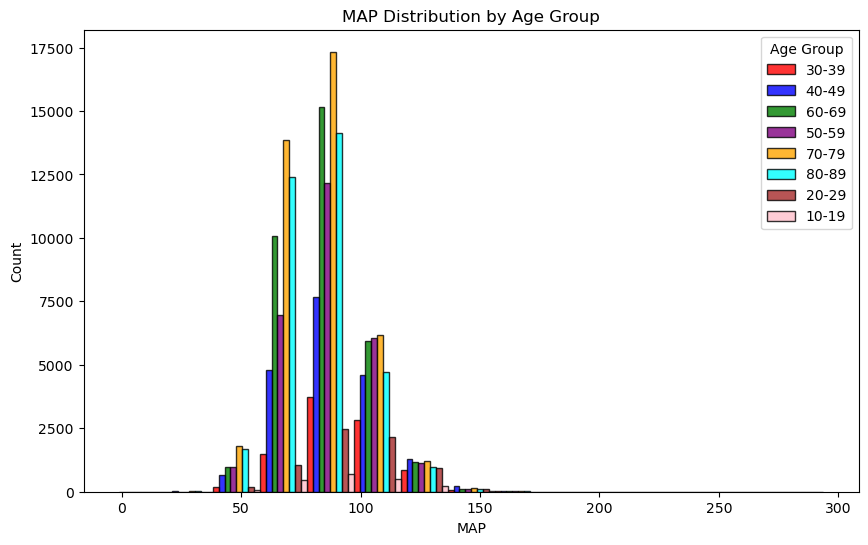

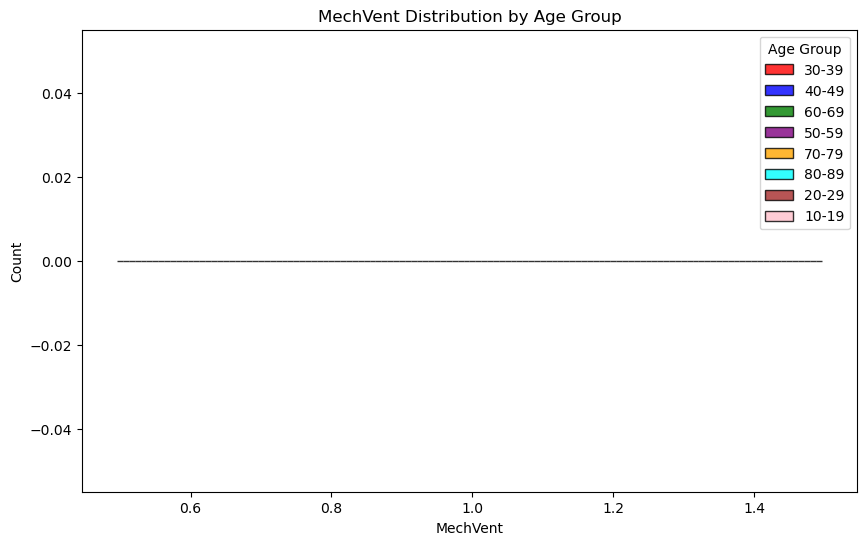

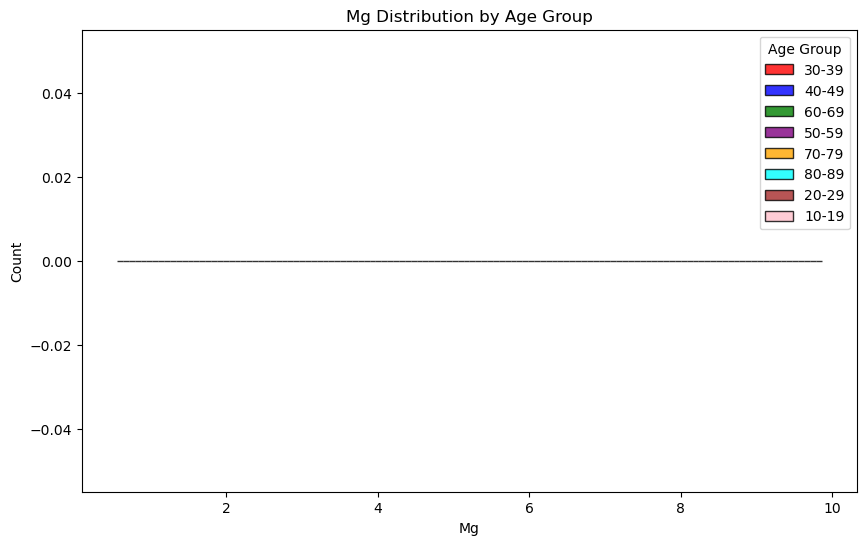

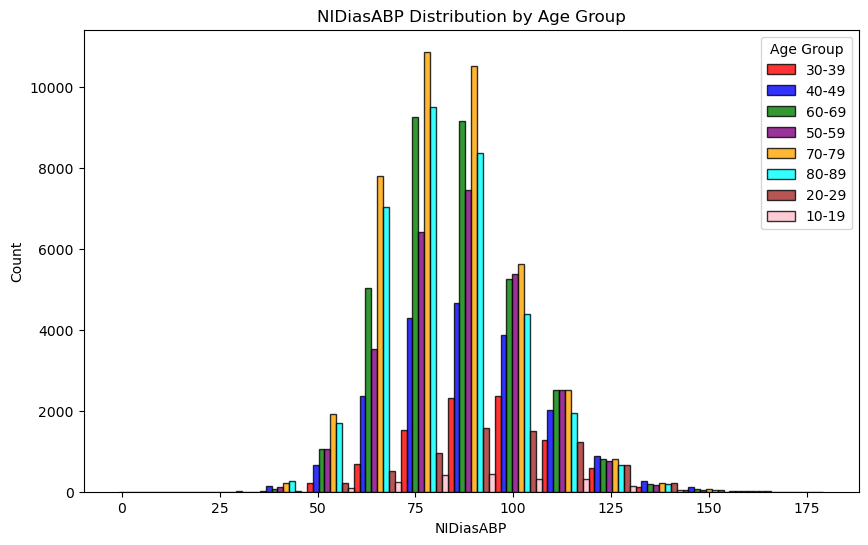

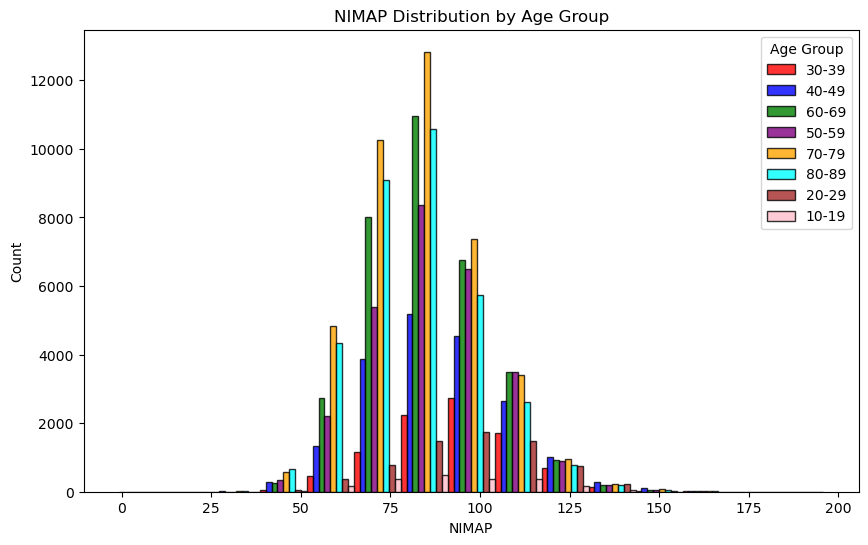

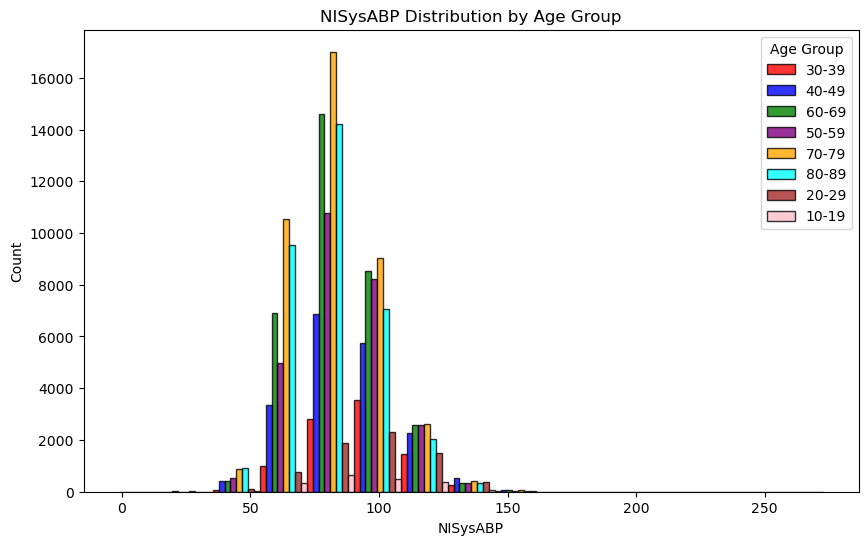

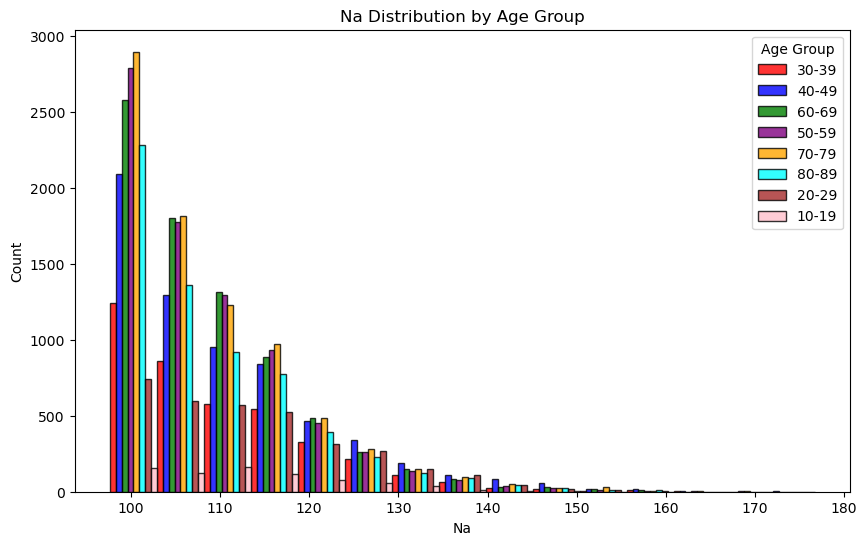

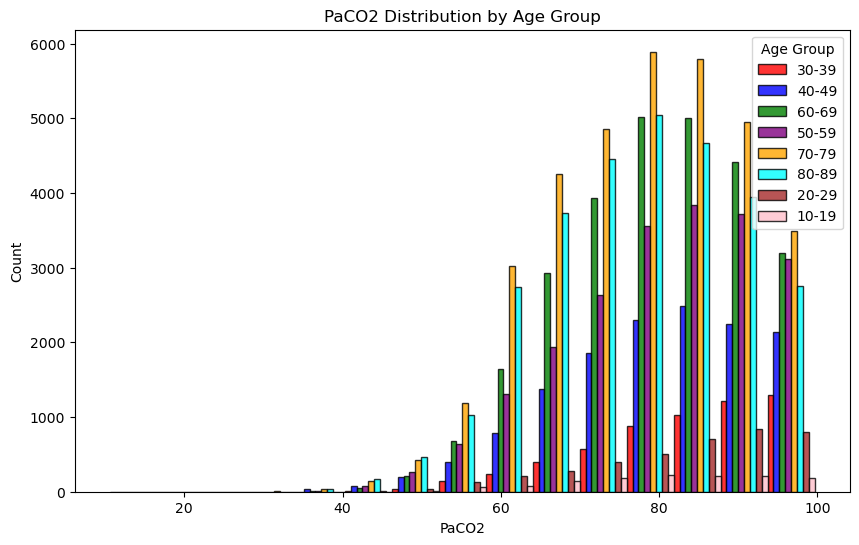

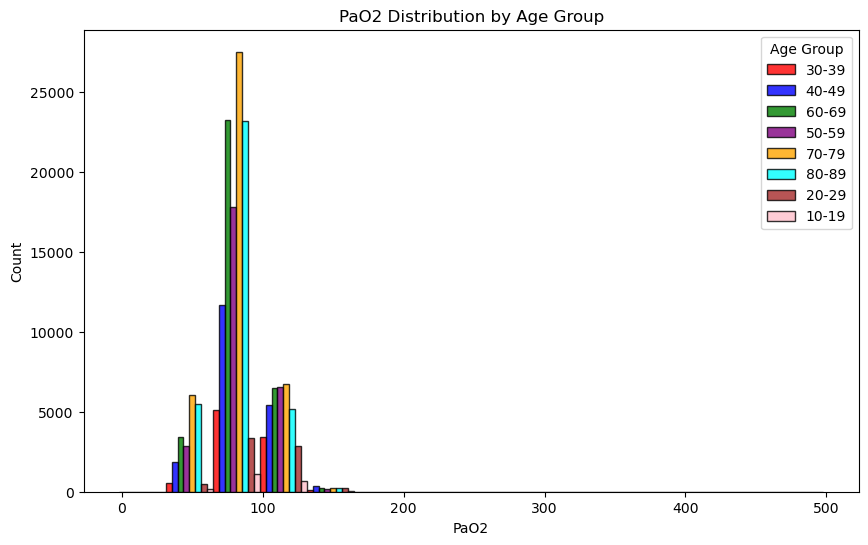

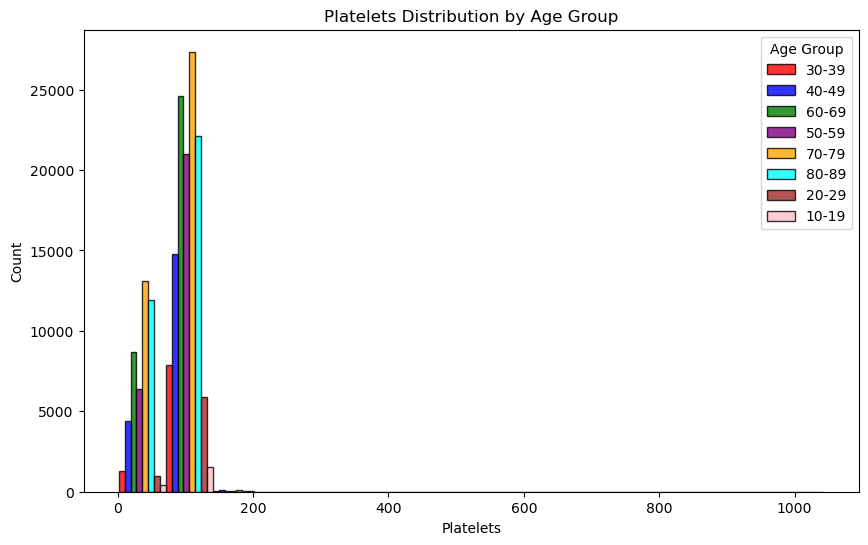

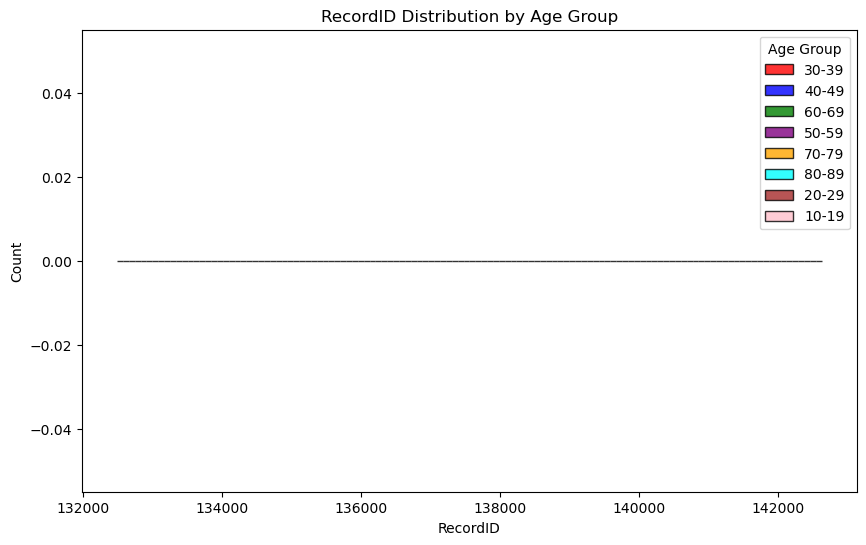

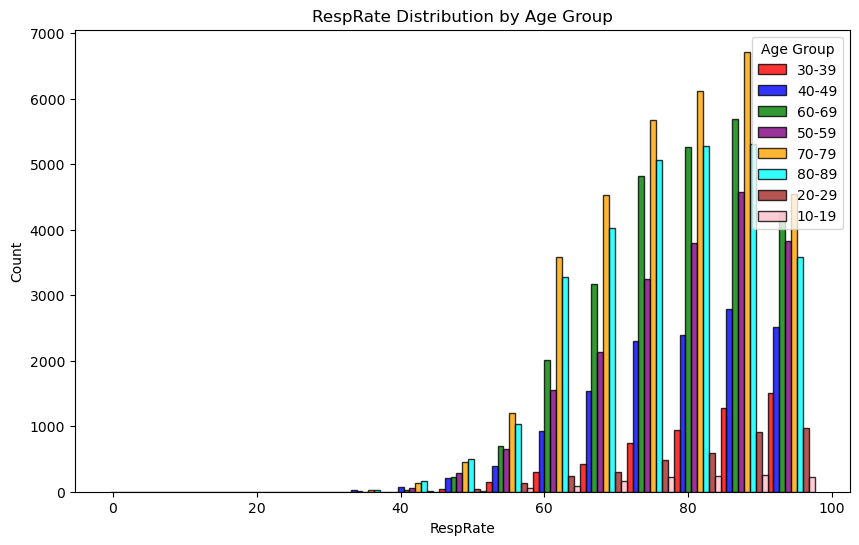

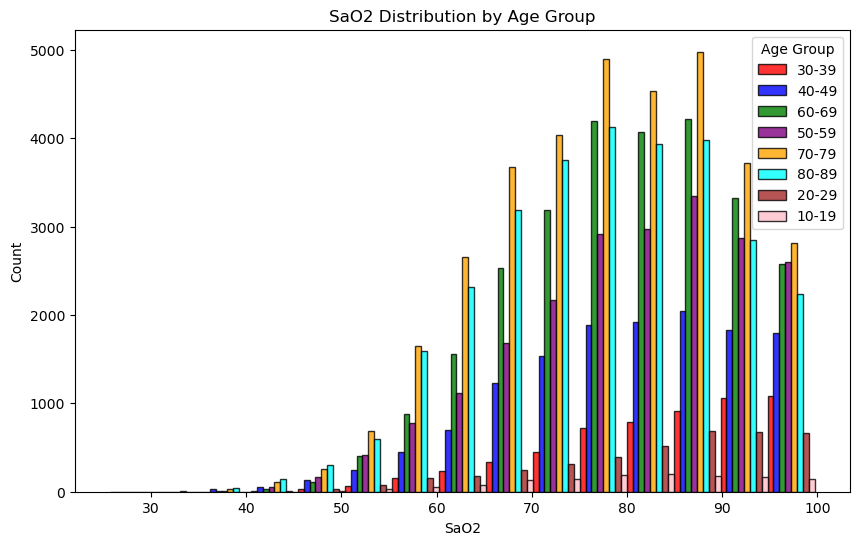

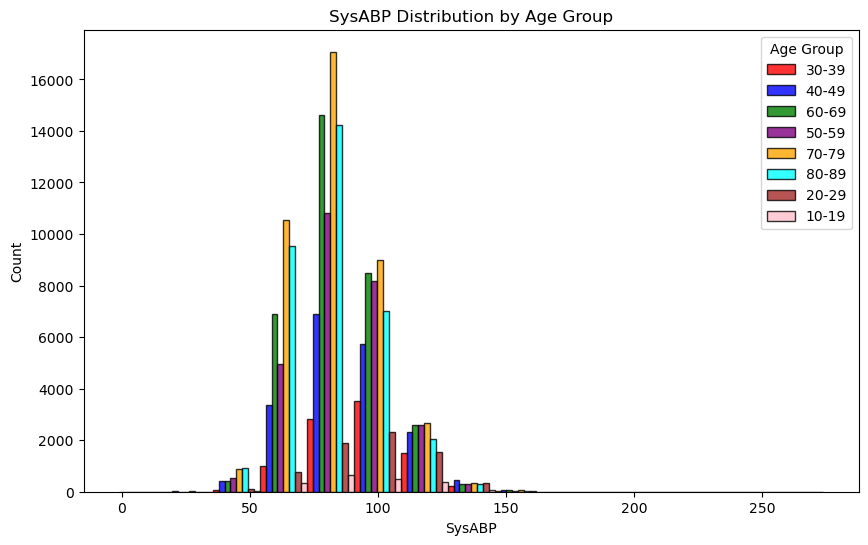

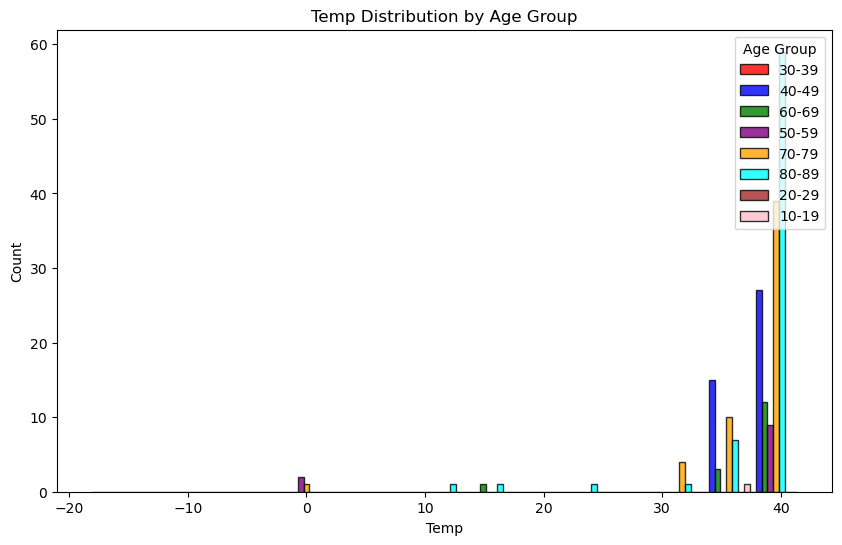

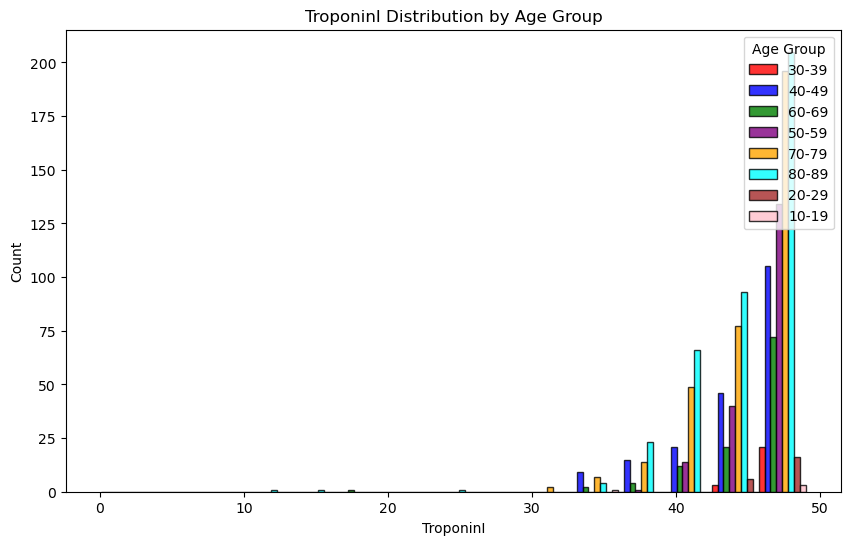

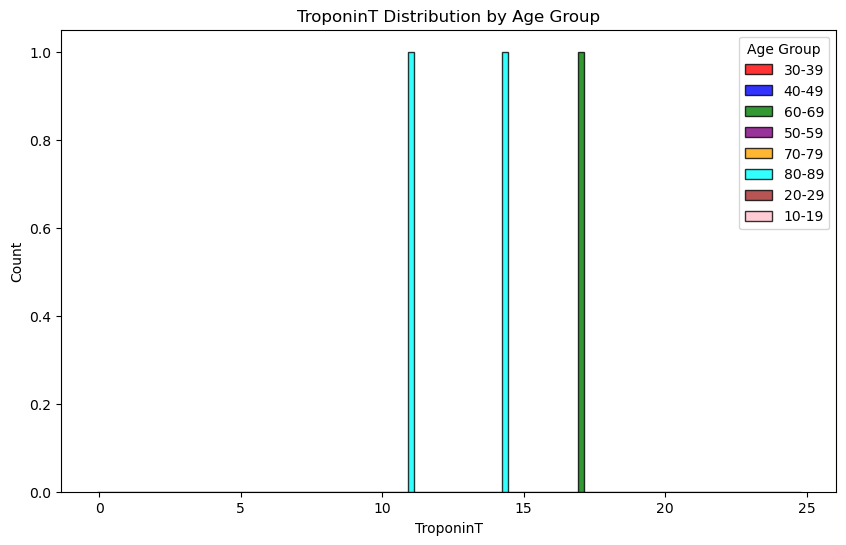

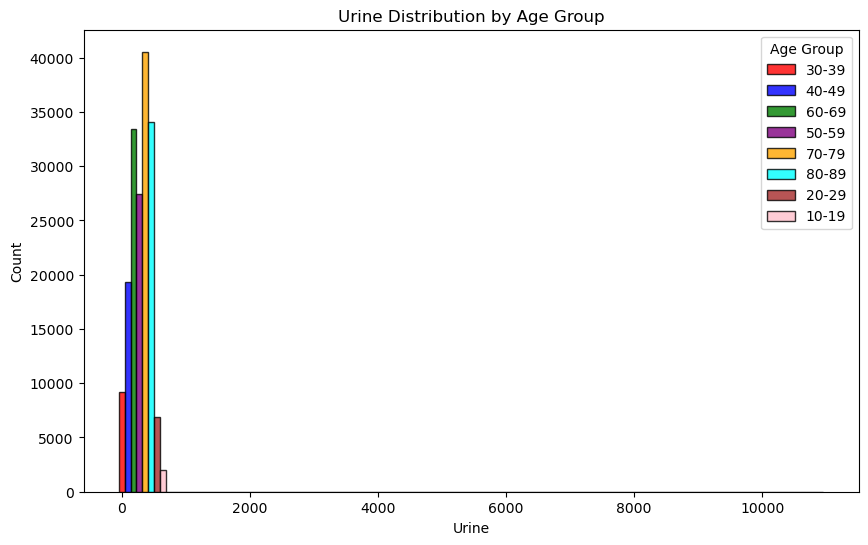

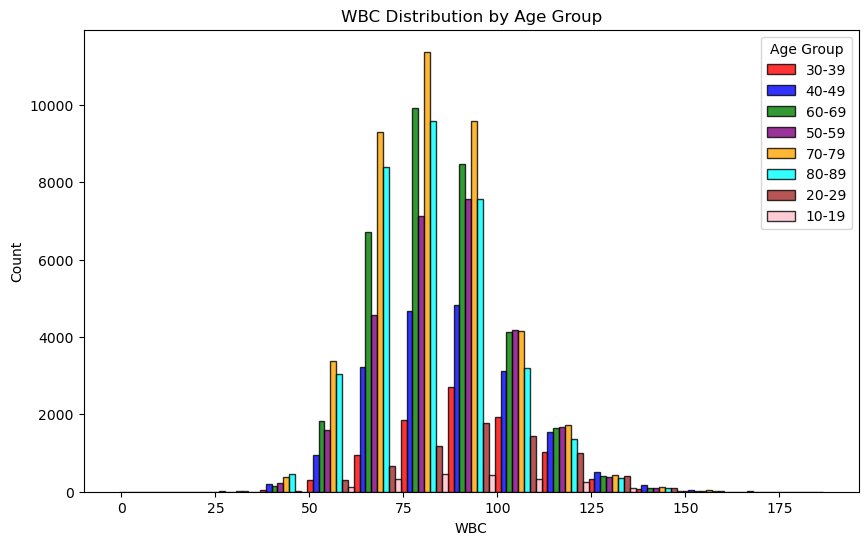

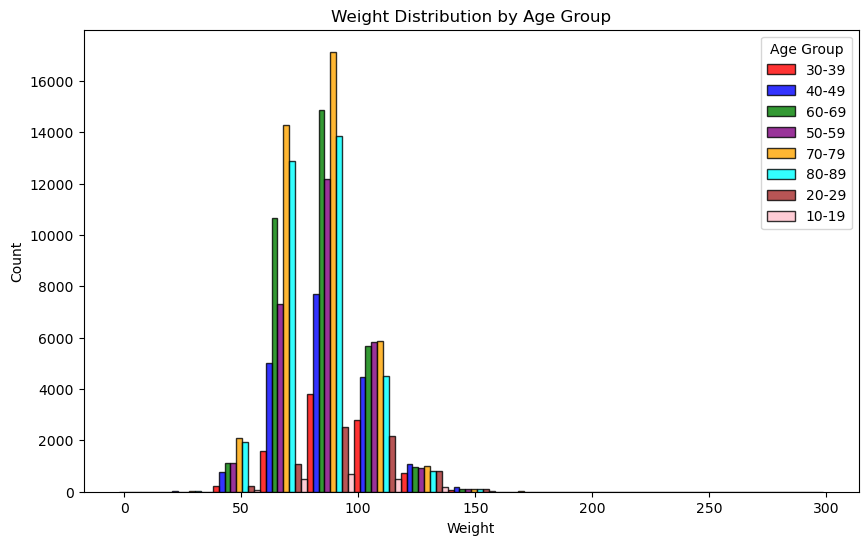

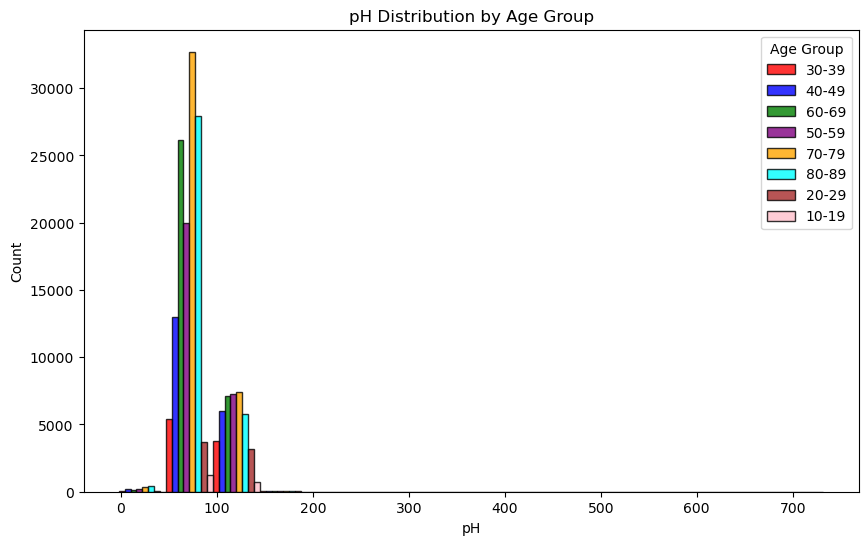

In [30]:
# Histograms of parameters by Gender

df = pd.read_parquet('processed-data/processed-set-a.parquet')

for e in unique_parameters:
    # Create a histogram
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=e, hue="Gender", bins=20, alpha=0.6, palette={1.0: "blue", 0.0: "red", -1.0: "green"})

    plt.title("Histogram of " + e + " by Gender")
    plt.xlabel(e)
    plt.ylabel("Frequency")
    plt.legend(title="Gender",labels=["Male","Female"])
plt.show()

In [ ]:
# Histograms of parameters by Age Group

df = pd.read_parquet('processed-data/processed-set-a.parquet')

# Create age bins (e.g., 0-9, 10-19, etc.)
bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
labels = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-99"]
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

for e in unique_parameters:
    # Create a histogram by AgeGroup with different colors for each bin
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=e, hue="AgeGroup", bins=20, alpha=0.6, palette="Set1")

    # Add title and labels
    plt.title("Histogram of " + e + " by Age Group")
    plt.xlabel(e)
    plt.ylabel("Frequency")
    plt.legend(title="Age Group", labels=labels)
    plt.show()

## Q1.3 Preprocess data for Machine Learning

NOTE: Does not yet handle NaN values which do not have a previous value

In [ ]:
# Loading datasets and performing forward filling (do this once for each of the processed datasets)
df = pd.read_parquet('processed-data/processed-set-c.parquet')
imputed_df = df.groupby("RecordID").ffill()
imputed_df.to_parquet('imputed-data/imputed-set-c.parquet', index=False)